# Testing isostatic boundary conditions in UW2

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     compressible air          |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |crust    | weaker  |  crust    |  ^ 
    |500 kg.  | crust   |           |  25 km 
    |_________|_________|___________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 


This is the same setup as the Isostasy 2 - Weaker blob model, but it now has sedimentation.

In this model, we use the pressure boundary condition at the base of the model.

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

from UWGeodynamics.surfaceProcesses import SedimentationThreshold

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True

# must be 0, because we use compressible air
GEO.rcParams["penalty"] = 0

# Use some higher order elements to get a nicer solution
GEO.rcParams["element.type"] = "Q2/dQ1"

# Use the fancier advection diffusion method
GEO.rcParams["advection.diffusion.method"] = "SLCN"

# Normally this is 0.5, but it can make it easier for the solver if you reduce this number.
GEO.rcParams["CFL"] = 0.25

# Adjust how particles populate the model. Because this model has a big load of inflowing material,
# I like to have these very aggressive
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [3]:
GEO.rcParams["output.directory"] = "simple_isos_1"

In [4]:
# This is all for scaling the model
# most of it is pretty self explanitory, try to make them match your setup as best as possible
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
# Setup the model domain and resolution. The 'divisor' is just an easy way to adjust the resolution
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [6]:
air      = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc       =  Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
weakzone =  Model.add_material(name="weak",  shape=GEO.shapes.Box(minX=-12.5*u.kilometer, maxX=12.5*u.kilometer, top=air.bottom, bottom=-25*u.kilometer))
mantle   = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="sediment")

# We use 'easy' numbers here, so the analytical calculation is easier.
air.density       =    1. * u.kilogram / u.metre**3
sediment.density  =  500. * u.kilogram / u.metre**3
uc.density        =  500. * u.kilogram / u.metre**3
weakzone.density  =  500. * u.kilogram / u.metre**3
mantle.density    = 1000. * u.kilogram / u.metre**3


air.viscosity      = 1e19 * u.pascal * u.second
uc.viscosity       = 1e21 * u.pascal * u.second
weakzone.viscosity = 2e20 * u.pascal * u.second
mantle.viscosity   = 1e20 * u.pascal * u.second
sediment.viscosity = 1e21 * u.pascal * u.second 


# we need to make the air compressible, so we can put a no infow boundary condition on the top of the model
air.compressibility = 1e3  # Not sure what's a good value

In [7]:
# So here we set the threshold to be 0 km. That means when the crust thins, and hence subsides, it is immediately
# replaced by sediment material. We therefor expect by the end of the model to have entirely replaced the crust
# and we should see 25 km of mantle, with 25 km of sediment on top.
Model.surfaceProcesses = GEO.surfaceProcesses.SedimentationThreshold(
    air=[air], 
    sediment=[sediment], 
    threshold=0.*u.kilometer)

In [8]:
# We need to initialise the model before calculating anything to serious (like the lithostatic pressure)
Model.init_model()

# This is where isostasy is imposed. We first calculate the lithostatic pressure along the entire bottom of the model. 
P, bottomPress = Model.get_lithostatic_pressureField()

# Then, since the model is laterally homogenous, we average it, and put it into megapascals
bottomPress = GEO.Dimensionalize(np.average(bottomPress), u.megapascal)


# This is where we apply the boundary conditions. As a rule of thumb, the more information we can give to UW, the happier
# it will be. For example, we could make the top a free slip condition:
#     top=[None , 0. * u.centimetre / u.year]
# but really, we don't care much about the top of the air, so giving 'extra info' in the form of a no-slip condition
# helps UW figure out what's going on.
# Try removing various bits of information to compare how the model performs.
Model.set_velocityBCs(left   = [-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right  = [1.0 * u.centimetre / u.year,  0 * u.centimetre / u.year], 
                      top    = [0 * u.centimetre / u.year,    0. * u.centimetre / u.year], 
                      bottom = [None,                         bottomPress]) # This is where the pressure boundary is applied.

In [9]:
# This is a bunch of solver options. You can try playing with them, but these should be good enough.
Model.solver = Model.stokes_solver()
Model.solver.options.A11.ksp_rtol=1e-8
Model.solver.options.scr.ksp_rtol=1e-8
Model.solver.options.scr.use_previous_guess = True
Model.solver.options.scr.ksp_set_min_it_converge = 10
Model.solver.options.scr.ksp_type = "cg"
Model.solver.options.main.remove_constant_pressure_null_space=True


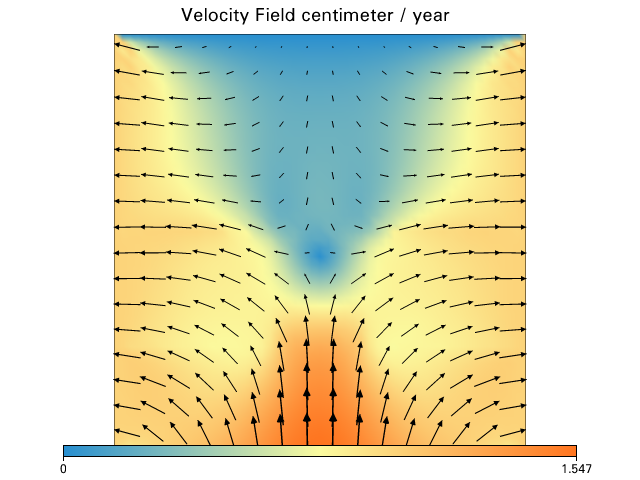


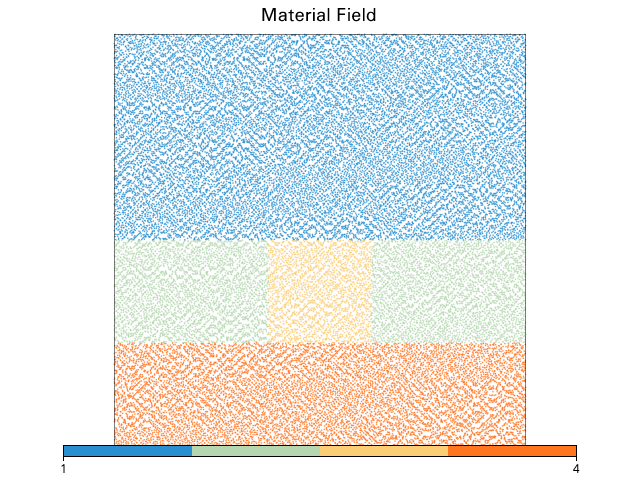

In [10]:
# Do an initial solve to give us a look at what's happening.
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

## Run model in a few increments, and show the results

In [11]:
Model.run_for(2.5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  16160.087906156608 year dt: 16160.08790615661 year (2018-10-25 05:22:18)
Step:2 Model Time:  36756.4285602372 year dt: 20596.340654080595 year (2018-10-25 05:22:18)
Step:3 Model Time:  59036.44365807372 year dt: 22280.01509783652 year (2018-10-25 05:22:19)
Step:4 Model Time:  78755.7892650819 year dt: 19719.34560700818 year (2018-10-25 05:22:19)
Step:5 Model Time:  100391.48376922717 year dt: 21635.69450414528 year (2018-10-25 05:22:19)
Step:6 Model Time:  124470.03901707951 year dt: 24078.555247852342 year (2018-10-25 05:22:20)
Step:7 Model Time:  149291.7421430593 year dt: 24821.703125979773 year (2018-10-25 05:22:20)
Step:8 Model Time:  172943.85629909232 year dt: 23652.114156033025 year (2018-10-25 05:22:21)
Step:9 Model Time:  194430.2531357999 year dt: 21486.396836707587 year (2018-10-25 05:22:21)
Step:10 Model Time:  219206.37663170559 year dt: 24776.123495905693 year (2018-10-25 05:22:21)
Step

Step:88 Model Time:  2112134.6828428106 year dt: 24933.902041908404 year (2018-10-25 05:22:51)
Step:89 Model Time:  2137104.917981956 year dt: 24970.235139145476 year (2018-10-25 05:22:51)
Step:90 Model Time:  2161985.8029560656 year dt: 24880.884974109504 year (2018-10-25 05:22:52)
Step:91 Model Time:  2186796.735624745 year dt: 24810.932668679376 year (2018-10-25 05:22:52)
Step:92 Model Time:  2211561.99457724 year dt: 24765.25895249535 year (2018-10-25 05:22:52)
Step:93 Model Time:  2236459.9410434198 year dt: 24897.94646617916 year (2018-10-25 05:22:53)
Step:94 Model Time:  2261356.2629137426 year dt: 24896.321870322936 year (2018-10-25 05:22:53)
Step:95 Model Time:  2286271.3423958276 year dt: 24915.0794820856 year (2018-10-25 05:22:53)
Step:96 Model Time:  2311189.4553186973 year dt: 24918.11292286934 year (2018-10-25 05:22:54)
Step:97 Model Time:  2336082.2501483015 year dt: 24892.794829604078 year (2018-10-25 05:22:54)
Step:98 Model Time:  2361007.787663054 year dt: 24925.53751

1


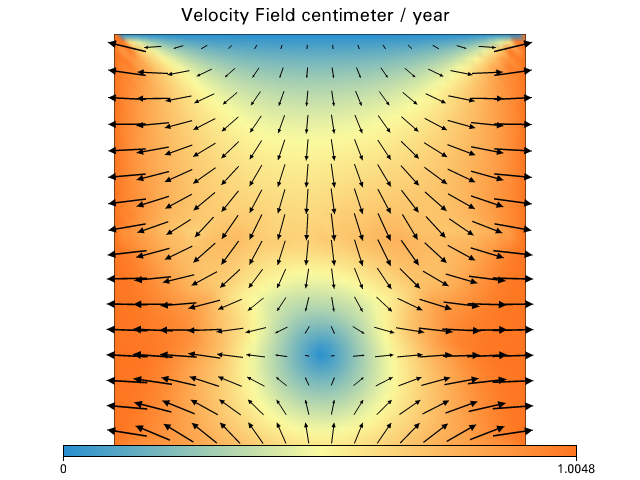


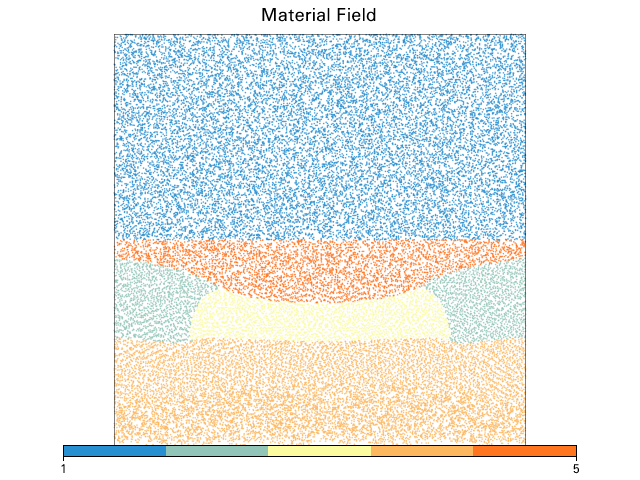

In [12]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [13]:
Model.run_for(2.5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  2524867.755698158 year dt: 24867.755698157336 year (2018-10-25 05:22:59)
Step:2 Model Time:  2549725.339513102 year dt: 24857.583814944384 year (2018-10-25 05:23:00)
Step:3 Model Time:  2574658.013075164 year dt: 24932.673562061802 year (2018-10-25 05:23:00)
Step:4 Model Time:  2599554.5305477516 year dt: 24896.51747258762 year (2018-10-25 05:23:01)
Step:5 Model Time:  2624442.4167170087 year dt: 24887.88616925701 year (2018-10-25 05:23:01)
Step:6 Model Time:  2649405.409448086 year dt: 24962.992731077382 year (2018-10-25 05:23:01)
Step:7 Model Time:  2674283.2115922933 year dt: 24877.802144207617 year (2018-10-25 05:23:02)
Step:8 Model Time:  2699139.4709283155 year dt: 24856.259336022027 year (2018-10-25 05:23:02)
Step:9 Model Time:  2724098.9771547844 year dt: 24959.50622646861 year (2018-10-25 05:23:02)
Step:10 Model Time:  2749003.838010198 year dt: 24904.860855413557 year (2018-10-25 05:23:03)
S

Step:88 Model Time:  4694657.964266884 year dt: 24972.610742054956 year (2018-10-25 05:23:33)
Step:89 Model Time:  4719623.965930405 year dt: 24966.001663521165 year (2018-10-25 05:23:34)
Step:90 Model Time:  4744600.40638408 year dt: 24976.44045367382 year (2018-10-25 05:23:34)
Step:91 Model Time:  4769563.213064594 year dt: 24962.80668051488 year (2018-10-25 05:23:34)
Step:92 Model Time:  4794482.727570384 year dt: 24919.51450578931 year (2018-10-25 05:23:35)
Step:93 Model Time:  4819442.15136762 year dt: 24959.423797235217 year (2018-10-25 05:23:35)
Step:94 Model Time:  4844366.188361623 year dt: 24924.036994003425 year (2018-10-25 05:23:36)
Step:95 Model Time:  4869296.964371927 year dt: 24930.776010304744 year (2018-10-25 05:23:36)
Step:96 Model Time:  4894234.889669903 year dt: 24937.92529797567 year (2018-10-25 05:23:36)
Step:97 Model Time:  4919169.605056938 year dt: 24934.715387035023 year (2018-10-25 05:23:37)
Step:98 Model Time:  4944127.288117882 year dt: 24957.683060943673

1


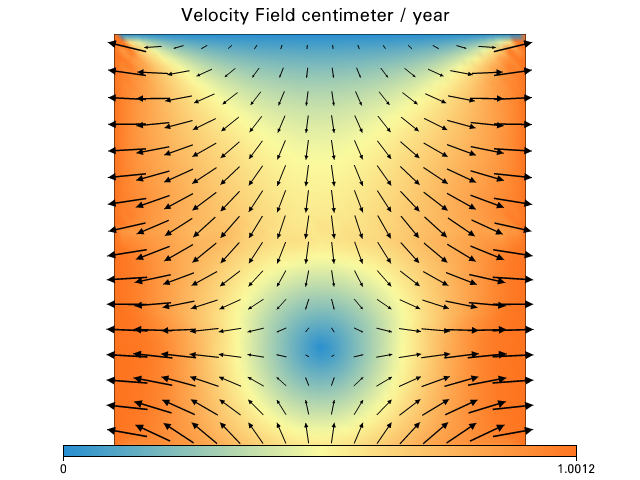


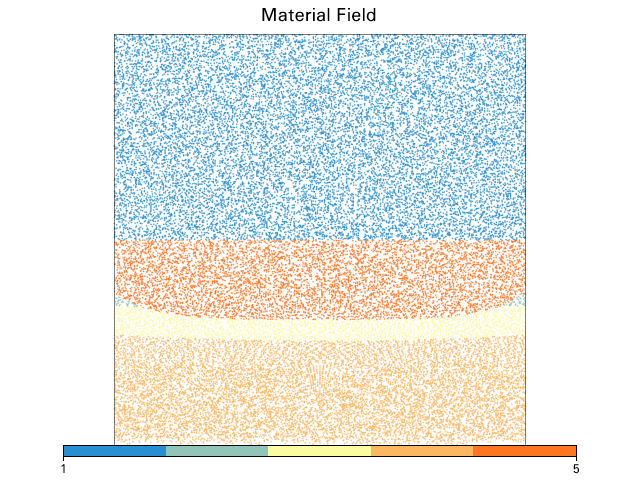

In [14]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [15]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  5024981.557286849 year dt: 24981.55728684737 year (2018-10-25 05:23:41)
Step:2 Model Time:  5049963.110205151 year dt: 24981.55291830201 year (2018-10-25 05:23:41)
Step:3 Model Time:  5074938.312823401 year dt: 24975.20261824962 year (2018-10-25 05:23:41)
Step:4 Model Time:  5099883.4138996145 year dt: 24945.101076213694 year (2018-10-25 05:23:42)
Step:5 Model Time:  5124846.078210338 year dt: 24962.664310723885 year (2018-10-25 05:23:42)
Step:6 Model Time:  5149808.396635699 year dt: 24962.318425360387 year (2018-10-25 05:23:42)
Step:7 Model Time:  5174776.418619776 year dt: 24968.02198407727 year (2018-10-25 05:23:43)
Step:8 Model Time:  5199742.802361786 year dt: 24966.38374201085 year (2018-10-25 05:23:43)
Step:9 Model Time:  5224658.910104377 year dt: 24916.107742590713 year (2018-10-25 05:23:44)
Step:10 Model Time:  5249577.285030626 year dt: 24918.37492624886 year (2018-10-25 05:23:44)
Step:11 

Step:88 Model Time:  7192412.024962448 year dt: 24913.812216307113 year (2018-10-25 05:24:14)
Step:89 Model Time:  7217300.877825927 year dt: 24888.852863479875 year (2018-10-25 05:24:15)
Step:90 Model Time:  7242214.617561992 year dt: 24913.739736065454 year (2018-10-25 05:24:15)
Step:91 Model Time:  7267109.048589206 year dt: 24894.431027213242 year (2018-10-25 05:24:15)
Step:92 Model Time:  7292056.31097548 year dt: 24947.26238627346 year (2018-10-25 05:24:16)
Step:93 Model Time:  7317018.645177136 year dt: 24962.33420165716 year (2018-10-25 05:24:16)
Step:94 Model Time:  7341897.993252016 year dt: 24879.348074879796 year (2018-10-25 05:24:16)
Step:95 Model Time:  7366767.910284535 year dt: 24869.917032519472 year (2018-10-25 05:24:17)
Step:96 Model Time:  7391677.839937523 year dt: 24909.92965298717 year (2018-10-25 05:24:17)
Step:97 Model Time:  7416589.6928798035 year dt: 24911.852942281086 year (2018-10-25 05:24:18)
Step:98 Model Time:  7441469.508758833 year dt: 24879.815879029

Step:175 Model Time:  9358263.433878276 year dt: 24841.642442941164 year (2018-10-25 05:24:48)
Step:176 Model Time:  9383146.859333698 year dt: 24883.42545542158 year (2018-10-25 05:24:48)
Step:177 Model Time:  9408054.797264941 year dt: 24907.93793124282 year (2018-10-25 05:24:48)
Step:178 Model Time:  9432979.218932766 year dt: 24924.421667826213 year (2018-10-25 05:24:49)
Step:179 Model Time:  9457889.478448492 year dt: 24910.259515724636 year (2018-10-25 05:24:49)
Step:180 Model Time:  9482842.978334272 year dt: 24953.499885780624 year (2018-10-25 05:24:50)
Step:181 Model Time:  9507610.076835822 year dt: 24767.098501550507 year (2018-10-25 05:24:50)
Step:182 Model Time:  9532502.039046863 year dt: 24891.962211040627 year (2018-10-25 05:24:50)
Step:183 Model Time:  9557433.40773581 year dt: 24931.368688946863 year (2018-10-25 05:24:51)
Step:184 Model Time:  9582379.137937497 year dt: 24945.730201688075 year (2018-10-25 05:24:51)
Step:185 Model Time:  9607315.146478532 year dt: 2493

1


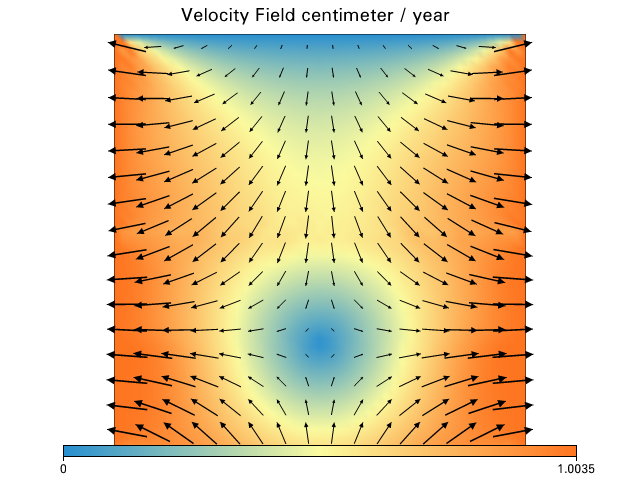


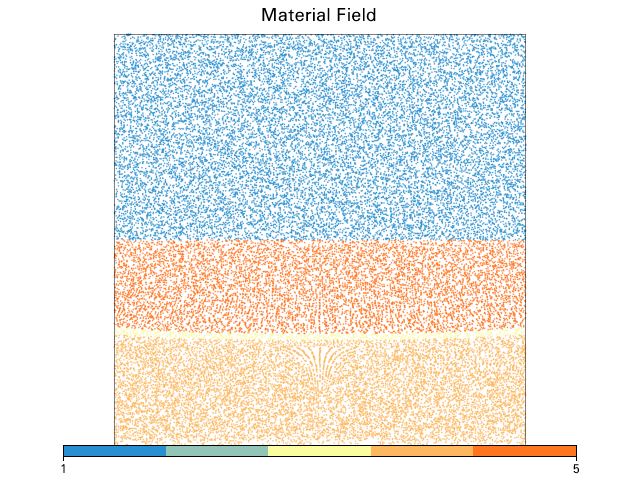

In [16]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)

In [17]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  10024879.540328963 year dt: 24879.540328962834 year (2018-10-25 05:25:00)
Step:2 Model Time:  10049853.95274771 year dt: 24974.41241874759 year (2018-10-25 05:25:01)
Step:3 Model Time:  10074763.921096707 year dt: 24909.96834899717 year (2018-10-25 05:25:01)
Step:4 Model Time:  10099581.265168246 year dt: 24817.344071538486 year (2018-10-25 05:25:01)
Step:5 Model Time:  10124529.83648261 year dt: 24948.57131436406 year (2018-10-25 05:25:02)
Step:6 Model Time:  10149495.680576175 year dt: 24965.84409356514 year (2018-10-25 05:25:02)
Step:7 Model Time:  10174357.277201643 year dt: 24861.596625468115 year (2018-10-25 05:25:02)
Step:8 Model Time:  10199198.702507991 year dt: 24841.42530634802 year (2018-10-25 05:25:03)
Step:9 Model Time:  10224119.848569669 year dt: 24921.146061677922 year (2018-10-25 05:25:03)
Step:10 Model Time:  10249007.813391335 year dt: 24887.964821666475 year (2018-10-25 05:25:04)


Step:88 Model Time:  12189973.071670525 year dt: 24934.74506068304 year (2018-10-25 05:25:35)
Step:89 Model Time:  12214852.955778461 year dt: 24879.88410793788 year (2018-10-25 05:25:36)
Step:90 Model Time:  12239676.974058477 year dt: 24824.018280015865 year (2018-10-25 05:25:36)
Step:91 Model Time:  12264455.946764965 year dt: 24778.97270648681 year (2018-10-25 05:25:37)
Step:92 Model Time:  12289269.179462804 year dt: 24813.232697838703 year (2018-10-25 05:25:37)
Step:93 Model Time:  12314123.711794252 year dt: 24854.532331448867 year (2018-10-25 05:25:37)
Step:94 Model Time:  12339076.09048276 year dt: 24952.37868850748 year (2018-10-25 05:25:38)
Step:95 Model Time:  12363997.910217931 year dt: 24921.819735171503 year (2018-10-25 05:25:38)
Step:96 Model Time:  12388841.524218185 year dt: 24843.614000253827 year (2018-10-25 05:25:39)
Step:97 Model Time:  12413615.998414205 year dt: 24774.474196020452 year (2018-10-25 05:25:39)
Step:98 Model Time:  12438542.647245063 year dt: 24926.

Step:174 Model Time:  14326980.471397847 year dt: 24801.07378320283 year (2018-10-25 05:26:09)
Step:175 Model Time:  14351756.864451967 year dt: 24776.393054119446 year (2018-10-25 05:26:09)
Step:176 Model Time:  14376593.593273474 year dt: 24836.728821507615 year (2018-10-25 05:26:10)
Step:177 Model Time:  14401480.983144896 year dt: 24887.389871421718 year (2018-10-25 05:26:10)
Step:178 Model Time:  14426373.893431457 year dt: 24892.91028656024 year (2018-10-25 05:26:11)
Step:179 Model Time:  14451211.87461445 year dt: 24837.9811829927 year (2018-10-25 05:26:11)
Step:180 Model Time:  14475968.65244391 year dt: 24756.77782946085 year (2018-10-25 05:26:11)
Step:181 Model Time:  14500772.559772924 year dt: 24803.907329012076 year (2018-10-25 05:26:12)
Step:182 Model Time:  14525621.93686655 year dt: 24849.377093626874 year (2018-10-25 05:26:12)
Step:183 Model Time:  14550493.229499266 year dt: 24871.292632714834 year (2018-10-25 05:26:13)
Step:184 Model Time:  14575376.966486009 year dt

1


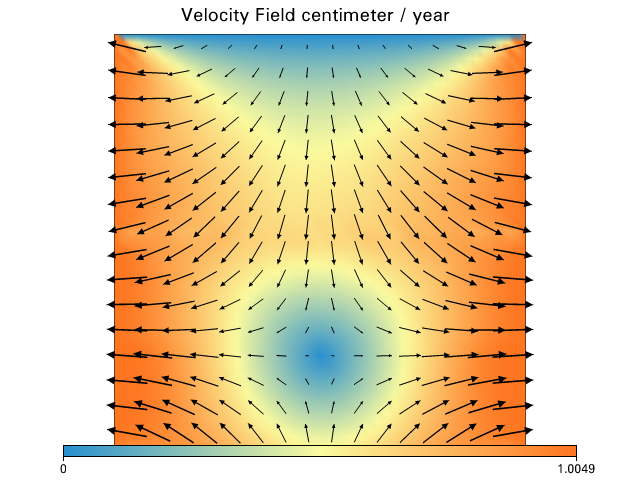


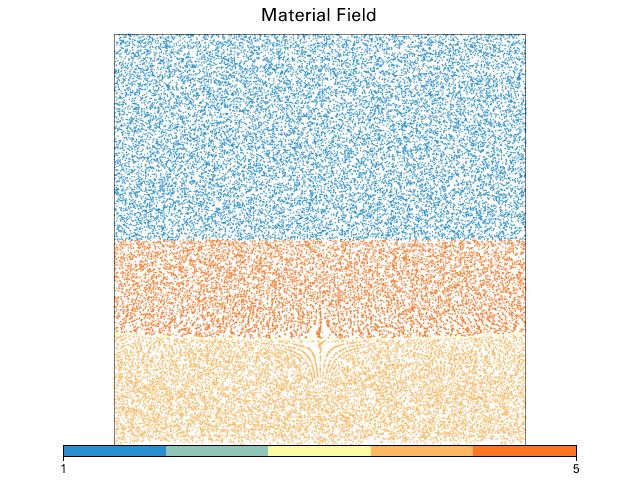

In [18]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [19]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  15024864.962450111 year dt: 24864.962450094674 year (2018-10-25 05:26:22)
Step:2 Model Time:  15049700.27535877 year dt: 24835.312908659198 year (2018-10-25 05:26:23)
Step:3 Model Time:  15074566.612634579 year dt: 24866.33727580817 year (2018-10-25 05:26:23)
Step:4 Model Time:  15099457.224387735 year dt: 24890.61175315651 year (2018-10-25 05:26:23)
Step:5 Model Time:  15124235.953407673 year dt: 24778.729019938535 year (2018-10-25 05:26:24)
Step:6 Model Time:  15149008.092362992 year dt: 24772.13895531886 year (2018-10-25 05:26:24)
Step:7 Model Time:  15173812.505755479 year dt: 24804.413392485367 year (2018-10-25 05:26:25)
Step:8 Model Time:  15198671.656422907 year dt: 24859.150667429672 year (2018-10-25 05:26:25)
Step:9 Model Time:  15223573.185039435 year dt: 24901.52861652628 year (2018-10-25 05:26:25)
Step:10 Model Time:  15248372.018516606 year dt: 24798.83347717123 year (2018-10-25 05:26:26)

Step:88 Model Time:  17184110.46609471 year dt: 24770.09101803741 year (2018-10-25 05:26:56)
Step:89 Model Time:  17208785.387786124 year dt: 24674.92169141544 year (2018-10-25 05:26:56)
Step:90 Model Time:  17233545.95768135 year dt: 24760.569895223536 year (2018-10-25 05:26:57)
Step:91 Model Time:  17258272.647981957 year dt: 24726.69030060798 year (2018-10-25 05:26:57)
Step:92 Model Time:  17283156.807590246 year dt: 24884.159608286594 year (2018-10-25 05:26:57)
Step:93 Model Time:  17308044.252172615 year dt: 24887.444582369895 year (2018-10-25 05:26:58)
Step:94 Model Time:  17332884.5612559 year dt: 24840.309083283653 year (2018-10-25 05:26:58)
Step:95 Model Time:  17357651.75655936 year dt: 24767.195303462013 year (2018-10-25 05:26:59)
Step:96 Model Time:  17382475.216060888 year dt: 24823.4595015308 year (2018-10-25 05:26:59)
Step:97 Model Time:  17407278.45440745 year dt: 24803.23834656168 year (2018-10-25 05:26:59)
Step:98 Model Time:  17432118.92849574 year dt: 24840.47408829

Step:175 Model Time:  19342482.463214695 year dt: 24853.830124774333 year (2018-10-25 05:27:30)
Step:176 Model Time:  19367342.619523253 year dt: 24860.1563085548 year (2018-10-25 05:27:30)
Step:177 Model Time:  19392204.52319878 year dt: 24861.903675523965 year (2018-10-25 05:27:31)
Step:178 Model Time:  19417051.810357917 year dt: 24847.28715914085 year (2018-10-25 05:27:31)
Step:179 Model Time:  19441912.028195214 year dt: 24860.21783729338 year (2018-10-25 05:27:31)
Step:180 Model Time:  19466708.159574 year dt: 24796.13137878657 year (2018-10-25 05:27:32)
Step:181 Model Time:  19491580.42794268 year dt: 24872.268368681885 year (2018-10-25 05:27:32)
Step:182 Model Time:  19516454.346663926 year dt: 24873.918721248432 year (2018-10-25 05:27:33)
Step:183 Model Time:  19541276.03569477 year dt: 24821.6890308424 year (2018-10-25 05:27:33)
Step:184 Model Time:  19566077.734853506 year dt: 24801.699158736472 year (2018-10-25 05:27:33)
Step:185 Model Time:  19590968.881730553 year dt: 248

1


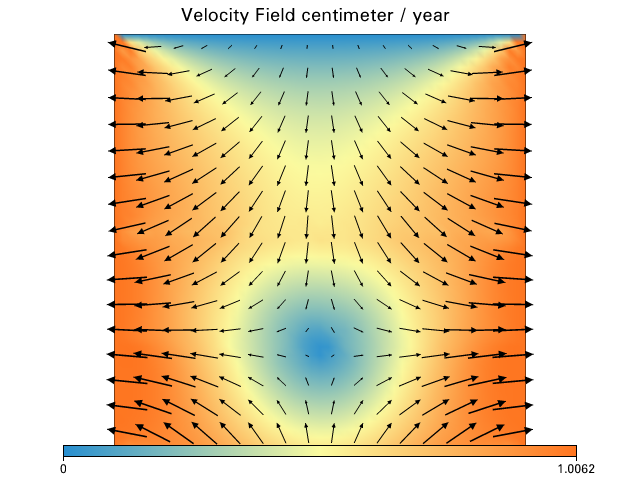


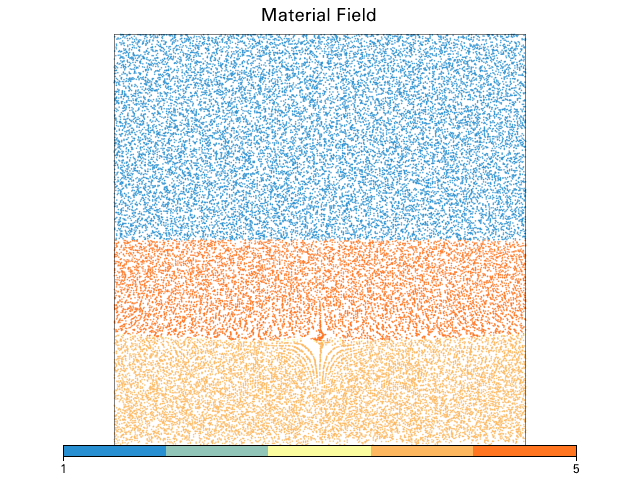

In [20]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)

# Summary

Everything performs as expected! Woo hoo!